In [1]:
import sentencepiece as spm
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as sps
import nlp

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from src.seq2seq_generator import Seq2Seq, Encoder, Decoder
from src.cnn_discriminator import CNNDiscriminator
from src.utils import *
from src.dataset import Dataset, Padder

import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

sns.set_style('whitegrid')

### 1. load data

In [2]:
dataset_name = 'news'

In [3]:
%%time

if dataset_name == 'cnn':
    train_dataset = nlp.load_dataset("cnn_dailymail", "3.0.0", split="train")
    val_dataset = nlp.load_dataset("cnn_dailymail", "3.0.0", split="validation")
    test_dataset = nlp.load_dataset("cnn_dailymail", "3.0.0", split="test")
    train_articles = [item['article'] for item in train_dataset]
    train_highlights = [item['highlights'] for item in train_dataset]
    val_articles = [item['article'] for item in val_dataset]
    val_highlights = [item['highlights'] for item in val_dataset]
elif dataset_name == 'news':
    news = pd.read_csv('data/news_summary.csv')
    news.headlines = [process_str(s) for s in news.headlines]
    news.text = [process_str(s) for s in news.text]
    X_train, X_test = train_test_split(news, test_size=0.3,
                                       random_state=42)
    train_articles = X_train.text.values
    train_highlights = X_train.headlines.values
    val_articles = X_test.text.values
    val_highlights = X_test.headlines.values

CPU times: user 653 ms, sys: 32.1 ms, total: 685 ms
Wall time: 684 ms


### 2. sentencepiece model

In [4]:
train_new_model = False

In [5]:
%%time
if train_new_model:
    with open('data/news_texts.txt', 'a') as f:
        for article in tqdm(train_articles):
            f.write(article + '\n')
        for highlight in tqdm(train_highlights):
            f.write(highlight + '\n')
        for article in tqdm(val_articles):
            f.write(article + '\n')
        for highlight in tqdm(val_highlights):
            f.write(highlight + '\n')
            
    spm.SentencePieceTrainer.train(input='data/news_texts.txt',
                                   model_prefix='news10k',
                                   vocab_size=10000,
                                   pad_id=0,
                                   bos_id=1,
                                   eos_id=2,
                                   unk_id=3)

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 2.38 µs


### 3. lda

In [6]:
bigram = False
lemmas = False
train_model = False
modelname = f'topic_models/news_train_bigram{bigram}_lemmas{lemmas}.model'

In [7]:
%%time

articles_train_words = process_texts(train_articles, bigram=bigram, lemmas=lemmas)
highlights_train_words = process_texts(train_highlights, bigram=bigram, lemmas=lemmas)

articles_val_words = process_texts(val_articles, bigram=bigram, lemmas=lemmas)
highlights_val_words = process_texts(val_highlights, bigram=bigram, lemmas=lemmas)

id2word = corpora.Dictionary(articles_train_words)

articles_train_corpus = [id2word.doc2bow(text) for text in articles_train_words]
highlights_train_corpus = [id2word.doc2bow(text) for text in highlights_train_words]

articles_val_corpus = [id2word.doc2bow(text) for text in articles_val_words]
highlights_val_corpus = [id2word.doc2bow(text) for text in highlights_val_words]

CPU times: user 27.1 s, sys: 248 ms, total: 27.4 s
Wall time: 27.4 s


In [8]:
%%time
if train_model:
    lda_model = gensim.models.ldamodel.LdaModel(corpus=articles_train_corpus,
                                                id2word=id2word,
                                                num_topics=10, 
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                alpha='auto',
                                                per_word_topics=True)
    lda_model.save(modelname)
else:
    lda_model = gensim.models.ldamodel.LdaModel.load(modelname)

lda_model.print_topics()

CPU times: user 23.6 ms, sys: 12 ms, total: 35.6 ms
Wall time: 34.8 ms


[(0,
  '0.031*"based" + 0.026*"million" + 0.020*"used" + 0.018*"startup" + 0.014*"using" + 0.013*"deal" + 0.012*"public" + 0.011*"worth" + 0.011*"months" + 0.010*"making"'),
 (1,
  '0.030*"khan" + 0.029*"tweeted" + 0.022*"air" + 0.020*"part" + 0.015*"elections" + 0.015*"shah" + 0.015*"upcoming" + 0.015*"user" + 0.014*"flight" + 0.013*"show"'),
 (2,
  '0.028*"india" + 0.022*"also" + 0.018*"years" + 0.013*"accused" + 0.011*"national" + 0.011*"arrested" + 0.011*"actress" + 0.010*"revealed" + 0.010*"leader" + 0.009*"according"'),
 (3,
  '0.081*"said" + 0.033*"added" + 0.019*"film" + 0.011*"would" + 0.010*"like" + 0.009*"actor" + 0.009*"singh" + 0.008*"people" + 0.007*"wrote" + 0.006*"media"'),
 (4,
  '0.063*"us" + 0.040*"president" + 0.024*"modi" + 0.023*"country" + 0.023*"pm" + 0.021*"trump" + 0.017*"pakistan" + 0.015*"narendra" + 0.013*"donald" + 0.011*"house"'),
 (5,
  '0.024*"china" + 0.022*"security" + 0.019*"car" + 0.015*"series" + 0.015*"led" + 0.015*"states" + 0.014*"away" + 0.014*

In [9]:
coherence_model_lda = CoherenceModel(model=lda_model,
                                     texts=articles_train_words,
                                     dictionary=id2word,
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.38893017640073324


### 4. Topic difference

In [10]:
articles_train_topics = [get_topic_vector(lda_model, text) for text in articles_train_corpus]
articles_train_ohe = [get_ohe_topic_vector(lda_model, text) for text in articles_train_corpus]
highlights_train_topics = [get_topic_vector(lda_model, text) for text in highlights_train_corpus]
highlights_train_ohe = [get_ohe_topic_vector(lda_model, text) for text in highlights_train_corpus]

articles_val_topics = [get_topic_vector(lda_model, text) for text in articles_val_corpus]
articles_val_ohe = [get_ohe_topic_vector(lda_model, text) for text in articles_val_corpus]
highlights_val_topics = [get_topic_vector(lda_model, text) for text in highlights_val_corpus]
highlights_val_ohe = [get_ohe_topic_vector(lda_model, text) for text in highlights_val_corpus]

cosines: mean 0.917, std 0.049
euclidean distances: mean 0.162, std 0.052


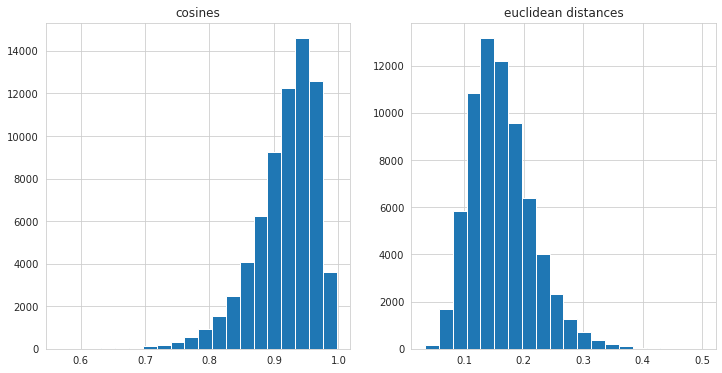

In [11]:
plot_distances(articles_train_topics, highlights_train_topics)

cosines: mean 0.917, std 0.049
euclidean distances: mean 0.16, std 0.051


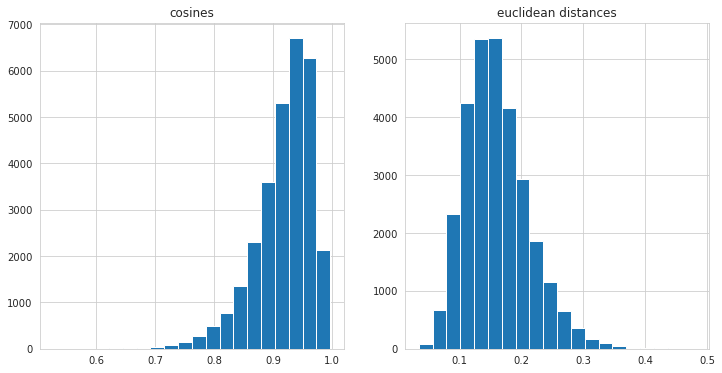

In [12]:
plot_distances(articles_val_topics, highlights_val_topics)

### 5. dataset and dataloaders

In [13]:
vocab_size = 10000
sp_modelname = f'sentencepiece_models/news{int(vocab_size/1000)}k.model'

In [14]:
sp = spm.SentencePieceProcessor(model_file=sp_modelname)

In [15]:
train_dataset = Dataset(train_articles, train_highlights, sp=sp)
val_dataset = Dataset(val_articles, val_highlights, sp=sp)

train_dataloader = DataLoader(train_dataset, batch_size=128,
                              collate_fn=Padder(), shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=128,
                            collate_fn=Padder(), shuffle=False)

In [16]:
for batch in train_dataloader:
    print(batch[0].size())
    print(batch[1].size())
    break

torch.Size([97, 128])
torch.Size([20, 128])


### 6. model architecture

In [17]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [18]:
writer = SummaryWriter()

In [19]:
INPUT_DIM = vocab_size
OUTPUT_DIM = vocab_size
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 256
N_LAYERS = 3
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

G = Seq2Seq(enc, dec, device).to(device)
save_path = 'saved_models/gen_adv.pth'
G.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [20]:
emb_dim = 256
hidden_dim = 256
vocab_size = 10000
padding_idx = 0
D = CNNDiscriminator(embed_dim=emb_dim,
                     vocab_size=vocab_size,
                     num_classes=2,
                     filter_sizes=[2, 3, 3],
                     num_filters=200,
                     padding_idx=padding_idx).to(device)
save_path = 'saved_models/dis2_adv.pth'
D.load_state_dict(torch.load(save_path))

<All keys matched successfully>

### 7. Topic difference for predictions

In [21]:
train_dataloader = DataLoader(train_dataset, batch_size=128,
                              collate_fn=Padder(), shuffle=False)

In [22]:
predicted_train = []
for i, batch in enumerate(train_dataloader):
    article = batch[0].to(device)
    highlight = batch[1].to(device)
    preds = G(article, highlight, teacher_forcing_ratio=0.)
    predicted_train += tensor_to_text(preds, sp)
    
predicted_val = []
for i, batch in enumerate(val_dataloader):
    article = batch[0].to(device)
    highlight = batch[1].to(device)
    preds = G(article, highlight, teacher_forcing_ratio=0.)
    predicted_val += tensor_to_text(preds, sp)
    
predicted_train_words = process_texts(predicted_train, bigram=bigram, lemmas=lemmas)
predicted_train_corpus = [id2word.doc2bow(text) for text in predicted_train_words]
predicted_train_topics = [get_topic_vector(lda_model, text) for text in predicted_train_corpus]
predicted_train_ohe = [get_ohe_topic_vector(lda_model, text) for text in predicted_train_corpus]

predicted_val_words = process_texts(predicted_val, bigram=bigram, lemmas=lemmas)
predicted_val_corpus = [id2word.doc2bow(text) for text in predicted_val_words]
predicted_val_topics = [get_topic_vector(lda_model, text) for text in predicted_val_corpus]
predicted_val_ohe = [get_ohe_topic_vector(lda_model, text) for text in predicted_val_corpus]

cosines: mean 0.907, std 0.057
euclidean distances: mean 0.17, std 0.056


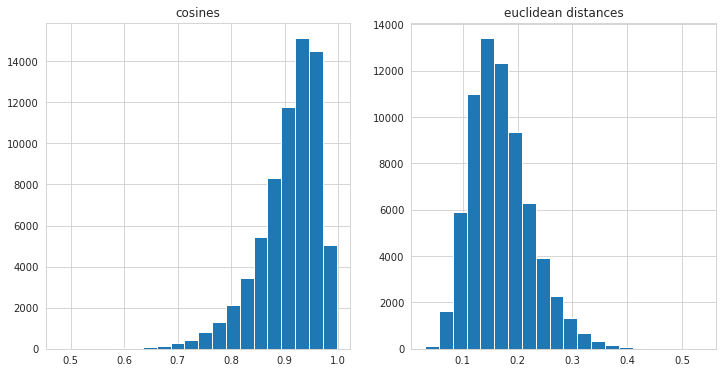

In [23]:
plot_distances(articles_train_topics, predicted_train_topics)

cosines: mean 0.902, std 0.061
euclidean distances: mean 0.173, std 0.057


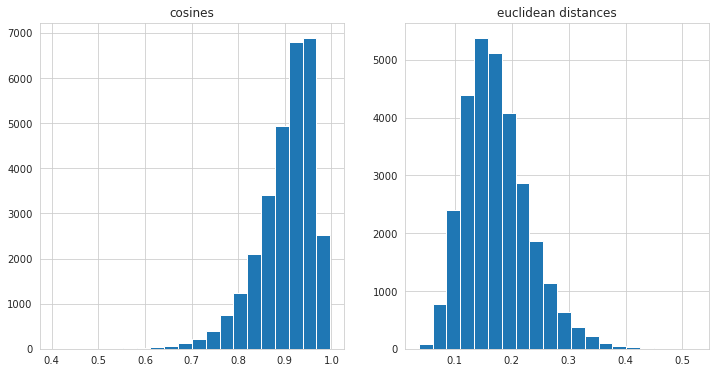

In [24]:
plot_distances(articles_val_topics, predicted_val_topics)

cosines: mean 0.957, std 0.038
euclidean distances: mean 0.098, std 0.049


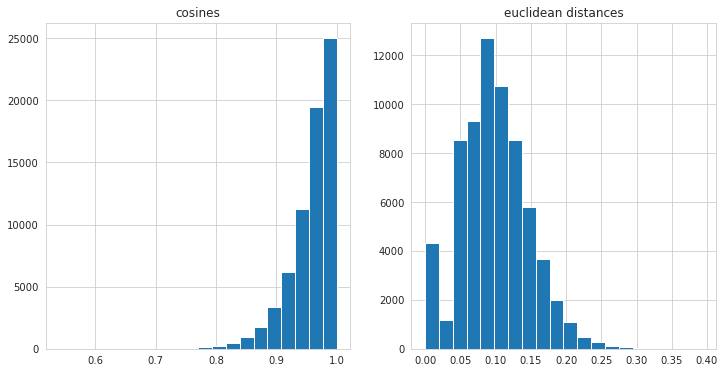

In [25]:
plot_distances(highlights_train_topics, predicted_train_topics)

cosines: mean 0.935, std 0.048
euclidean distances: mean 0.126, std 0.049


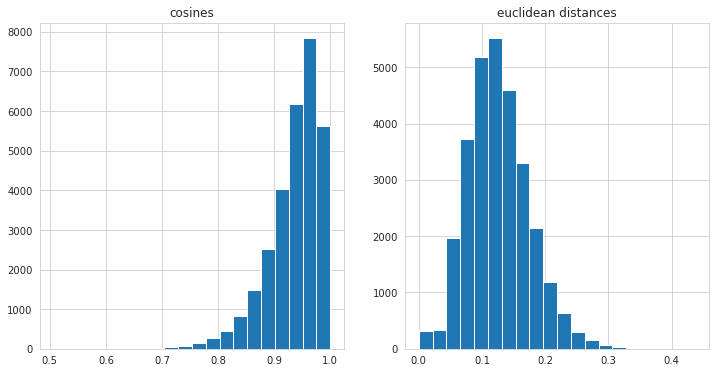

In [26]:
plot_distances(highlights_val_topics, predicted_val_topics)

### 8. adversarial training with topic difference reward

In [27]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [28]:
n_epochs = 20

In [29]:
writer = SummaryWriter()

In [30]:
G.train()

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(10000, 256)
    (rnn): LSTM(256, 256, num_layers=3, dropout=0.1)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(10000, 256)
    (rnn): LSTM(256, 256, num_layers=3, dropout=0.1)
    (out): Linear(in_features=512, out_features=10000, bias=True)
    (w): Linear(in_features=256, out_features=256, bias=True)
    (attn_lin): Linear(in_features=512, out_features=512, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [31]:
D.train()

CNNDiscriminator(
  (embed): Embedding(10000, 256, padding_idx=0)
  (convs): ModuleList(
    (0): Conv2d(1, 200, kernel_size=(2, 256), stride=(1, 1))
    (1): Conv2d(1, 200, kernel_size=(3, 256), stride=(1, 1))
    (2): Conv2d(1, 200, kernel_size=(3, 256), stride=(1, 1))
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=600, out_features=1, bias=True)
)

In [32]:
discriminator_optimizer = torch.optim.Adam(D.parameters(), lr=1e-2)
generator_optimizer = torch.optim.Adam(G.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss(ignore_index=0)
dis_criterion = nn.BCELoss()

G_losses = []
D_losses = []
iter_num = -1
G_ce_val_losses = []

for epoch_idx in range(n_epochs):
    total_G_loss = 0.
    total_D_loss = 0.
    G.train()
    D.train()
    for batch_idx, data_input in tqdm(enumerate(train_dataloader)):
        article = data_input[0].to(device)
        highlight = data_input[1].to(device)
        
        # Discriminator
        generated_highlight = G(article, highlight, teacher_forcing_ratio=0.)
        generated_highlight = torch.argmax(F.softmax(generated_highlight, dim=2), dim=2).permute(1, 0)
        batch = torch.cat([generated_highlight, highlight.permute(1, 0)], dim=0)
        targets = torch.tensor([0]*generated_highlight.size(0) + [1]*highlight.size(1)).to(device)
        discriminator_optimizer.zero_grad()
        generator_optimizer.zero_grad()
        out = D(batch)
        loss = dis_criterion(out.squeeze(1), targets.float())
        loss.backward()
        discriminator_optimizer.step()
        total_D_loss += loss.data.item() * highlight.size(1) * 2
        iter_num += 1
        writer.add_scalar('Loss/dis_adv_train', loss.data.item(), iter_num)
        
        # Generator
        generator_optimizer.zero_grad()
        discriminator_optimizer.zero_grad()
        gen_out = G(article, highlight, teacher_forcing_ratio=0.)
        
        texts = tensor_to_text(gen_out, sp)
        predicted_corpus = [id2word.doc2bow(text.split()) for text in texts]
        predicted_topics = [get_topic_vector(lda_model, text) for text in predicted_corpus]
        
        texts = tensor_to_text(article, sp)
        article_corpus = [id2word.doc2bow(text.split()) for text in texts]
        article_topics = [get_topic_vector(lda_model, text) for text in article_corpus]

        rewards = [cosine(article_topic, predicted_topic)
                   for article_topic, predicted_topic in zip(article_topics, predicted_topics)]
        rewards = torch.tensor(rewards).to(device)
        
        pg_loss = G.batch_pgloss(article, highlight, rewards)
        pg_loss.backward()
        generator_optimizer.step()
        writer.add_scalar('Loss/gen_pg_train', pg_loss.data.item(), iter_num)
        writer.add_scalar('Reward/train', torch.mean(rewards).item(), iter_num)
        total_G_loss += pg_loss.data.item() * article.size(1)

    G_losses.append(total_G_loss / len(train_dataset))
    D_losses.append(total_D_loss / len(train_dataset) / 2)
    print(f'epoch {epoch_idx} G loss: {G_losses[-1]}')
    print(f'epoch {epoch_idx} D loss: {D_losses[-1]}')
    
    G.eval()
    total_loss = 0.
    total_reward = 0.
    for batch_idx, data_input in tqdm(enumerate(val_dataloader), position=0, leave=True):
        article = data_input[0].to(device)
        highlight = data_input[1].to(device)
        rewards = D(highlight.permute(1, 0)).squeeze(1)
        gen_out = G(article, highlight, teacher_forcing_ratio=0.)
        
        texts = tensor_to_text(gen_out, sp)
        predicted_corpus = [id2word.doc2bow(text.split()) for text in texts]
        predicted_topics = [get_topic_vector(lda_model, text) for text in predicted_corpus]
        texts = tensor_to_text(article, sp)
        article_corpus = [id2word.doc2bow(text.split()) for text in texts]
        article_topics = [get_topic_vector(lda_model, text) for text in article_corpus]
        rewards = [cosine(article_topic, predicted_topic)
                   for article_topic, predicted_topic in zip(article_topics, predicted_topics)]
        rewards = torch.tensor(rewards).to(device)
        pg_loss = G.batch_pgloss(article, highlight, rewards)
        total_loss += pg_loss.data.item() * article.size(1)
        total_reward += torch.mean(rewards).item() * article.size(1)
    writer.add_scalar('Loss/gen_pg_val', total_loss / len(val_dataset), iter_num)
    writer.add_scalar('Reward/val', total_reward / len(val_dataset), iter_num)
    
    total_loss = 0.
    for batch_idx, data_input in tqdm(enumerate(val_dataloader), position=0, leave=True):
        article = data_input[0].to(device)
        highlight = data_input[1].to(device)
        out = G(article, highlight, teacher_forcing_ratio=0.)
        loss = criterion(out.permute(1, 2, 0), highlight.permute(1, 0))
        total_loss += loss.data.item() * article.size(1)

    G_ce_val_losses.append(total_loss / len(val_dataset))
    print(f'epoch {epoch_idx} val loss: {G_ce_val_losses[-1]}')
    writer.add_scalar('Loss/gen_ce_val', G_ce_val_losses[-1], iter_num)
    ind = sps.randint(0, out.size(1)).rvs(size=1)[0]
    print(f'predicted: {tensor_to_text(out, sp)[ind]}')
    print(f'truth: {tensor_to_text(highlight, sp)[ind]}')

539it [02:45,  3.27it/s]
1it [00:00,  6.90it/s]

epoch 0 G loss: 37.61108432009117
epoch 0 D loss: 0.018707683464375936


231it [00:34,  6.75it/s]
231it [00:13, 17.10it/s]
0it [00:00, ?it/s]

epoch 0 val loss: 6.2891813605091995
predicted: delhi cm kejriwal kejriwal defamation case over camera case
truth: delhi cm discharged in defamation case over thulla remark


539it [02:47,  3.21it/s]
1it [00:00,  6.90it/s]

epoch 1 G loss: 37.229180995310685
epoch 1 D loss: 0.0


231it [00:35,  6.55it/s]
231it [00:13, 16.60it/s]
0it [00:00, ?it/s]

epoch 1 val loss: 6.305165490202495
predicted: 18 priests get life term in jail for murder tmc tmc
truth: 18 cpi m men get life term for killing tmc workers in 2010


539it [02:48,  3.19it/s]
1it [00:00,  6.89it/s]

epoch 2 G loss: 36.98080093120293
epoch 2 D loss: 0.0


231it [00:35,  6.56it/s]
231it [00:13, 16.61it/s]
0it [00:00, ?it/s]

epoch 2 val loss: 6.257227437783134
predicted: aus australia australia a good word of game australia coach
truth: sledging is a fun part of the game aus coach justin langer


539it [02:49,  3.17it/s]
1it [00:00,  6.88it/s]

epoch 3 G loss: 37.23299238660798
epoch 3 D loss: 0.0


231it [00:35,  6.53it/s]
231it [00:13, 16.52it/s]
0it [00:00, ?it/s]

epoch 3 val loss: 6.310733335708918
predicted: delhi s i s ruled out of ipl 10 10 after 85 runs
truth: delhi s last year top scorer quinton de kock out of ipl 2017


539it [02:49,  3.19it/s]
1it [00:00,  6.89it/s]

epoch 4 G loss: 36.904030843022944
epoch 4 D loss: 0.0


231it [00:35,  6.56it/s]
231it [00:13, 16.54it/s]
0it [00:00, ?it/s]

epoch 4 val loss: 6.359622359069874
predicted: amitabh bachchan ss documents with ed panama papers
truth: amitabh aishwarya submit documents in panama papers probe


517it [02:42,  3.18it/s]


KeyboardInterrupt: 

In [ ]:
tensor_to_text(article, sp)

In [ ]:
# save_path = 'saved_models/dis2_adv.pth'
# torch.save(D.state_dict(), save_path)

# save_path = 'saved_models/gen_adv.pth'
# torch.save(G.state_dict(), save_path)